# Boat Instruments, Damping, and Filtering

## Summary

This notebook investigates the "central" boat instruments are filtered/smoothed/damped to provide useful.

- Raw instruments are measured with sensors that are quite noisy.
- Various techniques for filtering this noise to remove it.
   - The best approach appears to be a non-linear exponential filter.
- Additionally direct processing of angle data (like AWA) is tricky, we provide a technique which works better.


## Glossary

### Instruments and their Measurements
- AWA: apparent wind angle, the angle of the wind blowing at the top the mast (fast but noisy)
- AWS: apparent wind speed, the speed at the mast head (fast and noisy)
- SPD: boat speed **through the water** measured with the paddle wheel speedo in the hull (fast and noisy)
- HDG: compass heading (on PG this is magnetic northa and not true north, though easily corrected using magnetic variation/declination).
- COG and SOG: course and speed over ground from the GPS (these are relative to true north not magnetic on PG). These can differ from HDG/SPD because of current and leeway.

### Computed Quantities
- TWS: true wind speed, the speed of the wind over the ground (computed from the above quantities using the "wind triangle").
- TWD: true wind direction, the angle of the wind blowing over the ground (see "wind triangle").
- TWA: true wind angle, the angle of the wind over the ground reported relative the orientation of the boat (same)

### Other Quantities of Interest
- CURRENT: Speed of water flow triggered by tides.
- DEPTH: depth of water beneath the sensor.
- TIDES: Principally used to understand depth, and predict currents

In [1]:
# Load some libraries
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
from numba import jit

# These are libraries written for RaceAnalysis
import global_variables
G = global_variables.init_seattle()
import race_logs
import process as p
import analysis as a
import chart as c

In [2]:
import importlib
importlib.reload(race_logs)

<module 'race_logs' from '/Users/viola/GDriveBV/Sailboat/Code/Python/sailing/race_logs.py'>

In [3]:
# Info about all race logs are stored in a DataFrame.
log_info = race_logs.read_log_info()

examples = [race_logs.get_log(log_info, "2019-12-07"),
            race_logs.get_log(log_info, "2019-11-16")]
examples

[file              2019-12-07_09:47.pd.gz
 race                         Snowbird #2
 begin                              54316
 end                               109378
 datetime       2019-12-07 09:47:00-08:00
 description                 Snowbird #2.
 Name: 2, dtype: object, file              2019-11-16_10:09.pd.gz
 race                         Snowbird #1
 begin                              41076
 end                               111668
 datetime       2019-11-16 10:09:00-08:00
 description                 Snowbird #1.
 Name: 7, dtype: object]

In [4]:
dfs, big_df = race_logs.read_logs(examples, path=G.LOGS_DIRECTORY)
df = dfs[1]

Session from 2019-12-07 17:47:04, 124084 rows, 3.4466666666666668 hours.
Session from 2019-11-16 18:09:15.020000, 128865 rows, 3.5797222222222222 hours.


<IPython.core.display.Javascript object>


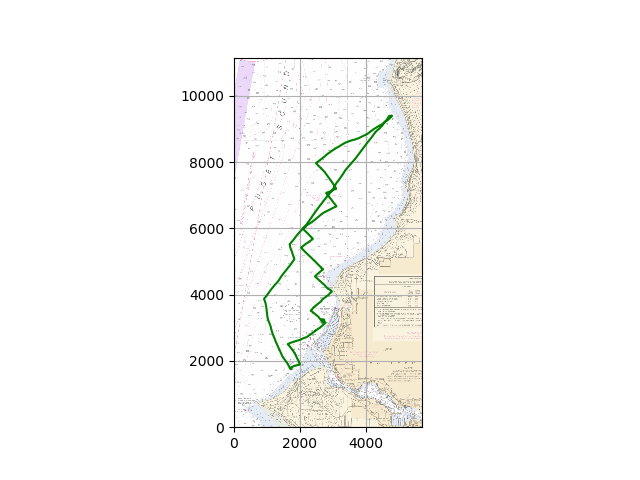

In [5]:
chart = c.plot_chart(df)
c.draw_track(df, chart, color='green')

## Raw Signals can be noisy

The wind sensor is located at the masthead, where it separately measures the wind speed (cups) and wind angle (vane). The top of the mast is a great place, because it is up above most of the airflow which can be disturbed by the sails.  The height of the masthead helps the sensor to be in the "freestream," away from the boundary layer which is close the surface.   Frequently the masthead will show more wind at a wider apparent angle than what is felt at the surface (this is called twist).

But the masthead is subject to large motions, as the boat rocks through waves and as the heel changes.  These introduce false readings.  Take a moment to stare at the vane while on the dock.  If the wind is light, you can rock the boat and the vane will swivel back and forth as the masthead moves.

Some discussion of these issues can be found here:

[B&G Wind Sensor](https://www.bandg.com/blog/vertical-wind-sensors-performance-sailing/)
[North Sails on Twist](https://www.northsails.com/sailing/en/2018/10/north-u-understanding-twist-by-bill-gladstone)

<IPython.core.display.Javascript object>


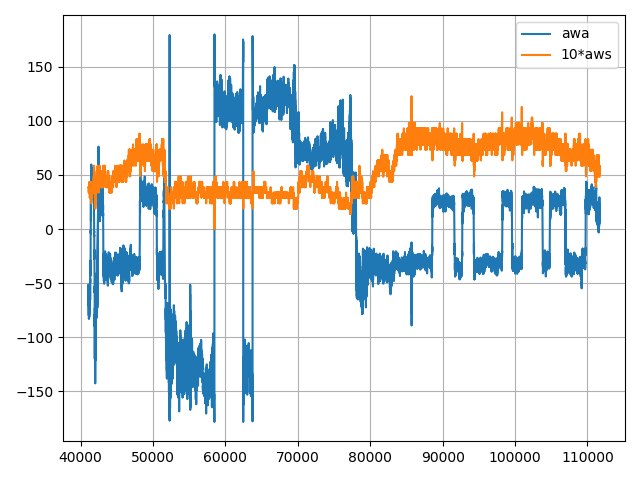

In [6]:
wdf = df
c.quick_plot(wdf.index, (wdf.rawa, 10*wdf.raws), "awa 10*aws".split())

<IPython.core.display.Javascript object>


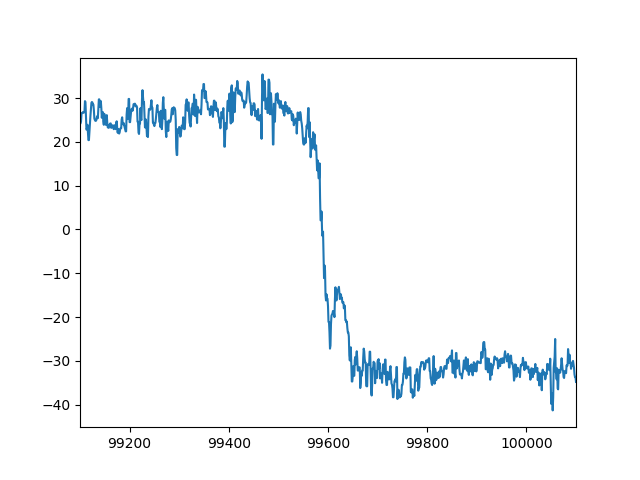

In [7]:
# Let's start by looking at just look at a bit of data, 100 seconds from the middle, centered on a tack.
delay = 100 * G.SAMPLES_PER_SECOND
start = 99100 # 87000

wide_slice = slice(start, start + delay)
wdf = df.loc[wide_slice]
plt.figure()
# RAWA is the raw values of AWA that are logged
wdf.rawa.plot()

# There are 10 samples per second, the ticks below are 200 samples, or 20 seconds.

<IPython.core.display.Javascript object>


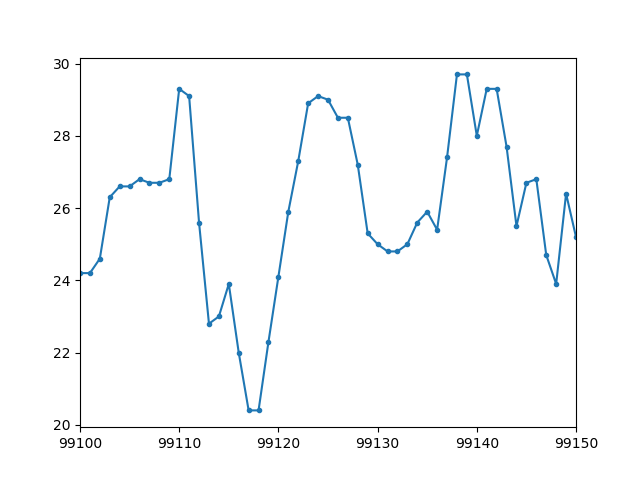

In [8]:
# Let's drill down and look at 5 seconds (50 samples)
narrow_slice = slice(start, start + 5 * G.SAMPLES_PER_SECOND)
ndf = df.loc[narrow_slice]
plt.figure()
ndf.rawa.plot(marker='.')

## Noise, Signal, Damping, and Filtering

Observe that apparent wind angle (AWA) appears "noisy".  Other raw instruments such as AWS, as well as boat speed (SPD), are similar.

Noise is pure randomness, there is no structure and no clear physical explanation.

But in the above signal there is clear evidence of rapid oscillation.  Most likely this is **not** noise.  Remember that the wind sensor is at the top of the mast, 50 feet above the water, where small changes in boat heel can lead to large and rapid movement side to side.  As the boat cuts through rhythmic waves, it is plausible that regular oscilation in wind angle would result.

But is this variation useful information?  Probably not.  Neither the boat, nor the wind, is rotating 9 degrees in 0.5 seconds.  So these variations might as well be noise, and we are better of "filtering" them away.

The true AWA is hidden in this noise; if you were to display the raw wind sensor readings the numbers would be jumping around like crazy, almost impossible to read.  (On many boats you can adjust display settings to display the raw instrument readings directly.  Its not very useful.)

On our B&G boat, these issues are addressed by "damping", which is left a bit mysterious in the Triton and Zeus B&G documentation.  Damping is a number from 0 to 10, with higher numbers providing more smoothing and less noise, while also introducing significant delay.  Further information on signal processing is provided in the documentation for some of the more advanced B&G sail computers: H5000 and WTP3.  Most likely the onboard units are using exponential filtering, perhaps a non-linear version.

Note, that what is logged for AWA is not what is shown on the instrument display (Triton and Zeus), because the mast head sensor unit broadcasts raw AWA, while the displays present a filtered/damped version, which is not logged.

On Peer Gynt, TWA (and TWS and TWD) are computed and broadcast by the autopilot computer (if the autopilot is off, then they missing from the logs).  These signals are damped **before** they are sent to other devices, including our logging device.

Since TWA is closely related to AWA, let's plot them both to get a sense of how damping works.

<IPython.core.display.Javascript object>


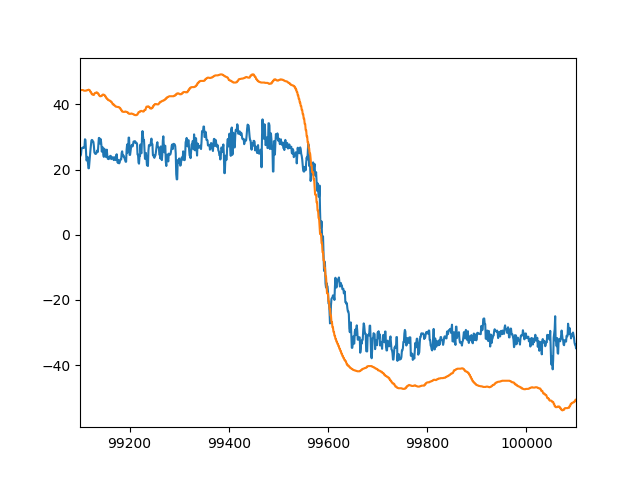

In [9]:
plt.figure()
# RAWA is the raw values of AWA that are logged
wdf.rawa.plot()
# And the "raw" TWA that is logged is quite different and much smoother.
wdf.rtwa.plot()

## So much noise

TWA is directly computed from AWA (using AWS, and SPD), and they are similar.  But there is a huge difference in noise. TWA is clearly filtered to remove noise.  

I am very impressed (or perhaps surprised) that the TWA computed on the boat seems to have very low delay (when AWA moves, TWA moves immediately aftward...  if not before!).  Smoothing always introduced some delay. 
How is dampling/filtering/smoothing computed?

## Butterworth Filter: noise vs. delay

I started out by implementing a number of classical smoothing filters, my favorite being the [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter).  The Butterworth is a [causal](https://en.wikipedia.org/wiki/Causal_filter) optimal linear filter, which is parameterized by its ORDER and its CUTOFF frequency.  Order is related to complexity of the filter and its delay, and we'll just assume 5.  Cutoff is the frequency above which the filter rejects noise.  The Butterworth attempts to pass signal below CUTOFF and reject signal above CUTOFF.  

Unfortunately there is no CUTOFF that can both smooth out the local noise and track the large jumps.  Butterworth also introduces quite a bit of delay.

<IPython.core.display.Javascript object>


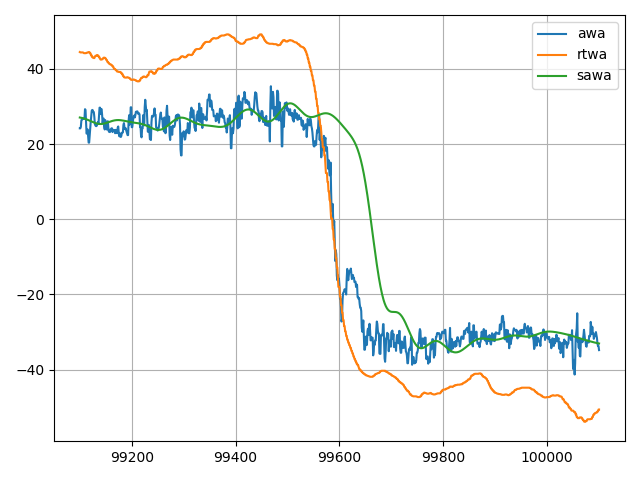

In [10]:
# Cutoff is the frequency of the underlying signal.
coeff = p.butterworth_filter(cutoff=0.15, order=5)

# Smooth angle applies the filter, with special handling of angles that wrap around at 360.
df['butter_causal_awa'] = p.smooth_angle(coeff, df.rawa, causal=True)
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rawa, wdf.rtwa, wdf.butter_causal_awa), "awa rtwa sawa".split())

## Smoother, but with a large delay.

Notice that the Butterworth signal is both more wiggly that TWA **and** very delayed (perhaps 6 seconds). In general, lowering the cutoff reduces the noise (removes wiggles) but increases delay.  Conversely, larger cutoff reduces delay, but the noise grows as a result.

<IPython.core.display.Javascript object>


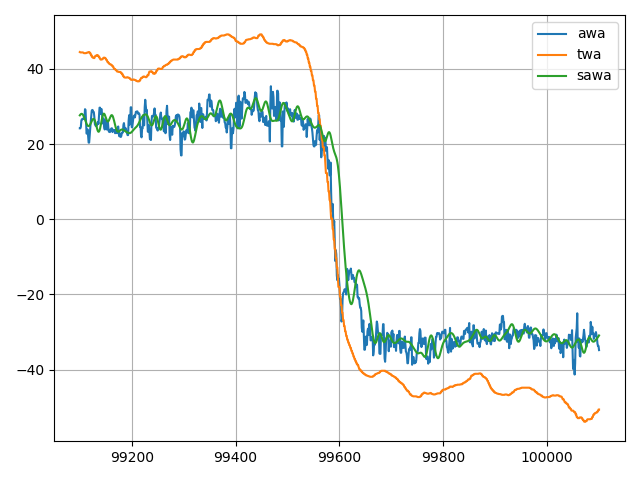

In [11]:
# Let's raise the cutoff, which will smooth less and delay more.
coeff = p.butterworth_filter(cutoff=0.6, order=5)

df['butter_causal_awa'] = p.smooth_angle(coeff, df.rawa, causal=True)
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rawa, wdf.rtwa, wdf.butter_causal_awa), "awa twa sawa".split())

Above we see that delay is reduced, but now there are more wiggles than TWA.

## Non-causal Filters Eliminate Delay

To eliminate the delay there is a standard [non-causal](https://en.wikipedia.org/wiki/Causal_filter) trick one can use: first filter the signal forward in time and then backward in time.  This **cannot** be used in real-time while you are sailing, since the entire signal must be available before processing (non-causal analysis is done afterward).  My main motivation in this analysis is to understand what the boat does, and to create algorithms that might be used on the boat.

## Exponential Filtering

After digging through various writings on boat instrument processing I discovered an offhand comment regarding non-linear filtering.  The basic idea is to implement a non-linear version of an exponential filter.  The exponential filter is perhaps the simplest smoothing filter, which can be implemented with very little processing:

$$ o_{t} = \alpha o_{t-1} + (1 - \alpha) i_t $$

where $o_t$ is the output and $i_t$ is the input.  Larger values of $\alpha$ (up to 1.0) yield more smoothing (and more delay).  Smaller values of $\alpha$ yield more noise, and less delay.  If $\alpha = 0$ then $o_t = i_t$ 

Note, the exponential filter is linear and is a close cousin of the Butterworth.  It could be called a Butterworth of order 1 (which does not seem to exist).

An exponential filter is very easy to implement, even on a tiny old computer.  But it is also primitive, providing poor filtering of noise.  If you want smoother filtering, then the smoothed signal is delayed (perhaps worse than a Butterworth).  

*Note, We are not going to discuss `@jit`.  It is a cool hack to make code run very fast in Python. [LINK](http://numba.pydata.org/)*

In [12]:
@jit(nopython=True)
def simple_exponential_filter(sig, alpha):
    res = np.zeros(sig.shape)
    res[0] = sig[0]
    for i in range(1, len(sig)):
        res[i] = alpha * res[i-1] + (1-alpha) * sig[i]
    return res

<IPython.core.display.Javascript object>


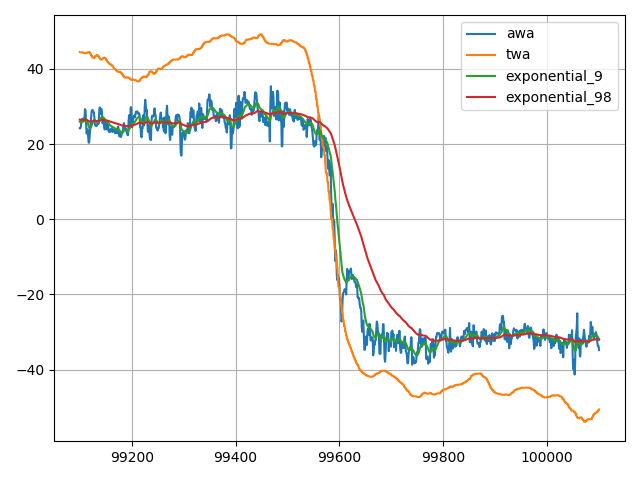

In [13]:
df['eawa_1'] = simple_exponential_filter(np.array(df.rawa), 0.9)
df['eawa_2'] = simple_exponential_filter(np.array(df.rawa), 0.98)

wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.rtwa, wdf.eawa_1, wdf.eawa_2), 
                         "awa twa exponential_9 exponential_98".split())

Exponential filters appear to have the same problem that Butterworth has.

## Non-linear Exponential

The advantage is the the exponential filter is very simple, and easy to modify.  For example we can introduce a **tracking error threshold**:

- If the tracking error is large then reduce alpha.
   - Tracking error is the difference between the filtered output and the raw input.
- If the tracking error is small then increase alpha (gradually back to original).

There are a couple of magic numbers here, like the threshold and how much to decrease or increase the value of alpha (which are hard to set).  Code is below.  

Note, the code for filtering angles is a bit more complex (angles wrap around at 360).  Below is the simpler (non-angle) version.

In [14]:
@jit(nopython=True)
def exponential_filter(sig, alpha, max_error):
    """
    Apply a non-linear exponential filter, where alpha is the decay (higher alpha is longer decay and higher smoothing).  If the error is
    greater than max_error, then alpha is repeatedly reduced  (faster decay).
    """
    beta = beta0 = 1 - alpha  # A bit easier to deal with beta, than alpha
    res = np.zeros(sig.shape)
    betas = np.zeros(sig.shape)
    res[0] = sig[0]
    betas[0] = beta
    for i in range(1, len(sig)):
        res[i] = (1 - beta) * res[i-1] + beta * sig[i]
        # Is the output far off the input signal?
        if np.abs(res[i] - sig[i]) > max_error:
            # If so increase beta
            beta = min(1.5 * beta, 0.5)
        else:
            # Else decrease beta back to initial beta
            beta = (beta + beta0) / 2
        betas[i] = beta
    return res, betas

### Why is this a good filter?  

All filters are trying to remove the noise from the true underlying signal. When sailing, a good model for true AWA (or true TWA or HDG) is that the true signal usually changes slowly (between tacks and gybes), except when there are large step changes (at tacks/gybes).  So AWA/AWS/HDG and other signals look a bit like a classic [square wave](https://en.wikipedia.org/wiki/Square_wave).

Imagine an exponential filter which had advanced knowledge of each tack. This magic filter could use two values of alpha, say 0.99 between the tacks (to smooth out the noise) and 0.5 during the tacks (to track the large changes).  The non-linear exponential filter adjusts alpha by looking at the output of the filter.  If the tracking is poor, then the signal must be in the step regime, so alpha is reduced.  If tracking is good then alpha is increased.

The Butterworth and the exponential filter are stuck processing using a single compromise value of alpha.

(Note, I suppose this sort of processing could be justified by a two state hidden markov model (HMM) which could work along similar lines.)

<IPython.core.display.Javascript object>


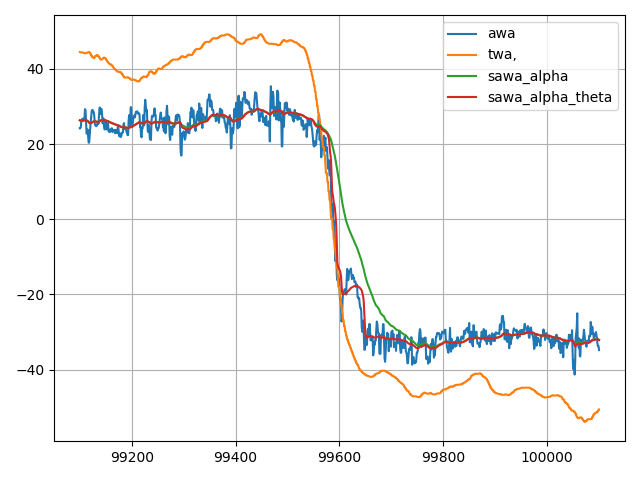

<IPython.core.display.Javascript object>


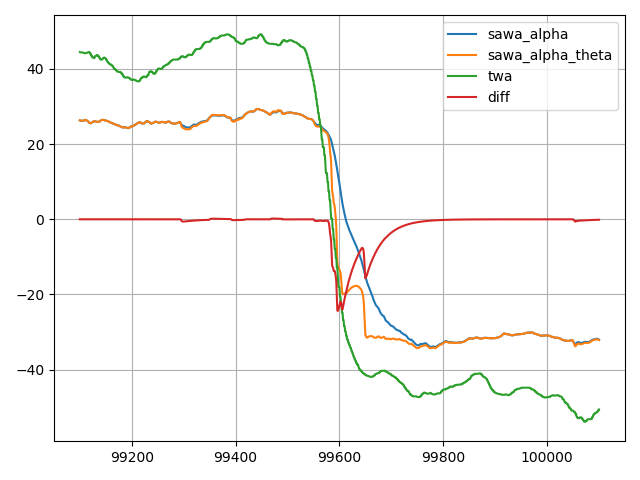

In [15]:
# In order to better understand this filter, we will focus on AWA (and use the smoothness of TWA as a reference).

# Above we used 10,000 for max_error, which essentially reduced the filter to simple exponential filter.
# We'll pick more reasonable values here.
max_error = 6  # the threshold, which should be roughly the magnitude of the noise 
alpha = 0.97
df['sawa_alpha'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, 10000)
df['sawa_alpha_theta'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, max_error)

wdf = df.loc[wide_slice]
diff = wdf.sawa_alpha_theta - wdf.sawa_alpha

# This new filtered signal closely tracks AWA, while rejecting most of the noise.
c.quick_plot(wdf.index, (wdf.rawa, wdf.rtwa, wdf.sawa_alpha, wdf.sawa_alpha_theta), 
                        "awa twa, sawa_alpha sawa_alpha_theta".split())


# Second plot is a bit cleaner because it leaves out the RAWA
c.quick_plot(wdf.index, (wdf.sawa_alpha, wdf.sawa_alpha_theta, wdf.rtwa, diff), 
                        "sawa_alpha sawa_alpha_theta twa diff".split())

In the above figure DIFF shows the difference between the linear and non-linear exponential filter. Where the difference is ZERO the max error threshold is not doing much.  We can see that MAX_ERROR only plays a role in the regions of the tack (where a rapid change in AWA is triggered).  Between the tacks, there is no difference between the two signals.

**How is theta determined?** In this case by eye.  After selecting a threshold, like 6, you can examine the tracking error to see if the signal strays far from the raw.

Try varying theta below, for larger values the smoothed value does not track through the tack.  For smaller values the noise gets worse.

<IPython.core.display.Javascript object>


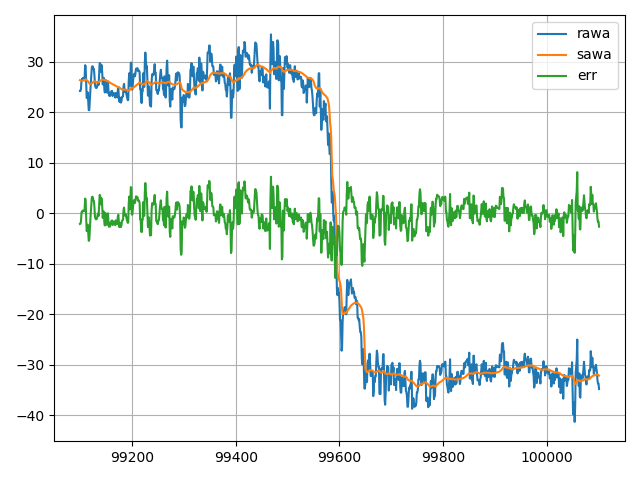

In [16]:
theta = 6 # the threshold, which should be approximate the noise 
alpha = 0.97
df['sawa_alpha_theta'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, theta)

wdf = df.loc[wide_slice]

err = wdf.rawa - wdf.sawa_alpha_theta
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa_alpha_theta, err), 
                        "rawa sawa err".split())

We can see that the ERR signal looks a lot like random noise (or perhaps it is the noise introduced by the motion of the mast).  And the noise has a peak to peak magnitude of about of about 6.

<IPython.core.display.Javascript object>


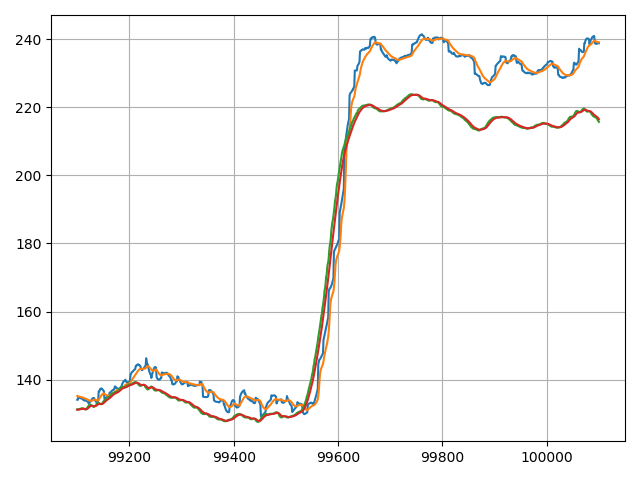

<IPython.core.display.Javascript object>


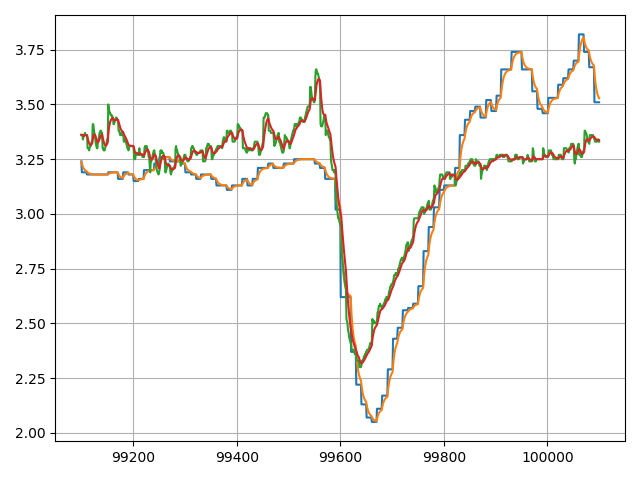

In [40]:
# Note different signals require different settings of alpha, because they have different 
# dynamics and noise.
theta = 6
alpha = 0.97
df['sawa'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, theta)

# Less noise and smaller theta values.
df['saws'], _ = p.exponential_filter(np.array(df.raws), 0.95, 0.6)
df['sspd'], _ = p.exponential_filter(np.array(df.rspd), 0.8, 0.5)
df['ssog'], _ = p.exponential_filter(np.array(df.rsog), 0.8, 0.5)

df['shdg'], _ = p.exponential_filter_angle(np.array(df.rhdg), 0.8, 6)
df['scog'], _ = p.exponential_filter_angle(np.array(df.rcog), 0.9, 6)


wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.rcog, wdf.scog, wdf.rhdg, wdf.shdg))
c.quick_plot(wdf.index, (wdf.rspd, wdf.sspd, wdf.rsog, wdf.ssog))


## Processing angles can be tricky

Their are two problems with angles:

1. Wrap around (which we mentioned above):  Angle 355 and 005 are "far" in value, but close in meaning.
2. Instability when speeds are low.  It is very hard to measure the angle of wind when wind speed is low (any noise, or motion of the boat can dwarf the true signal).  

Angle instability is not an issue when you can measure angle directly, with a compass for example (which does not require motion).  But it is an issue when motion is necessary, such as AWA, TWA, TWD, and even COG.  The weathervane that measures AWA is not very stable as the wind speed reduces to zero (below 2 knots).  COG, which is measured by the GPS unit, is only defined with SOG is measurably above zero.  I first noticed this because the GPS unit does not even output COG until we are away from the doc!

What does this mean in practice?  **The noise in an angule is larger when speeds are low.** 

In the first race below, the wind was much lower.

<IPython.core.display.Javascript object>


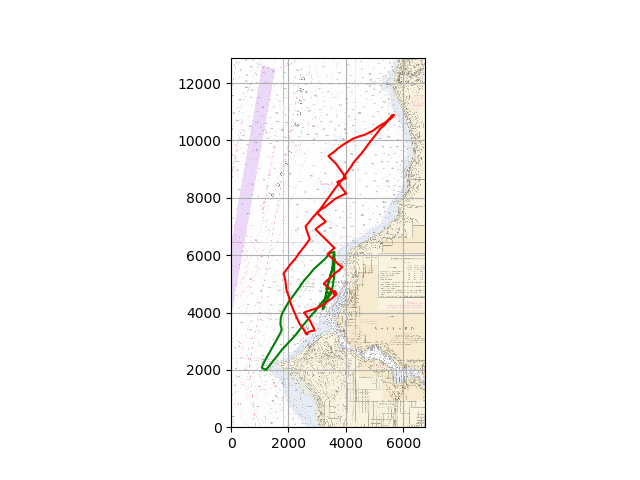

In [18]:
df = dfs[1]

chart = c.plot_chart(big_df)
c.draw_track(dfs[0], chart, color='green')
c.draw_track(dfs[1], chart, color='red')



<IPython.core.display.Javascript object>


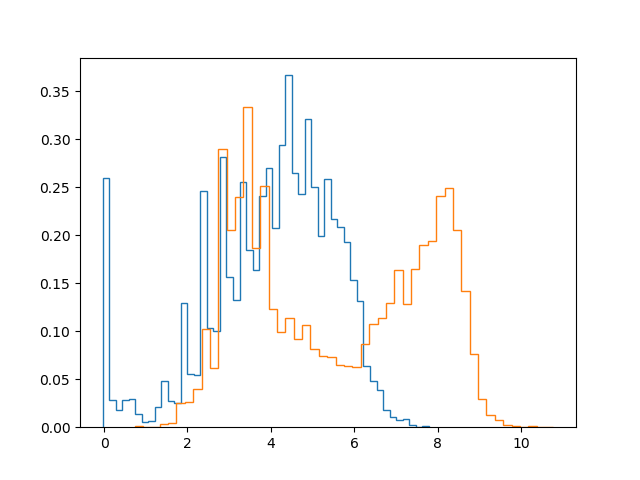

Average wind speed #0 is 3.991792402359996
Average wind speed #1 is 5.56308400413031


In [19]:
plt.figure()
plt.hist(dfs[0].aws, bins=50, histtype='step', density=True)
plt.hist(dfs[1].aws, bins=50, histtype='step', density=True)

print(f"Average wind speed #0 is {dfs[0].aws.mean()}")
print(f"Average wind speed #1 is {dfs[1].aws.mean()}")

<IPython.core.display.Javascript object>


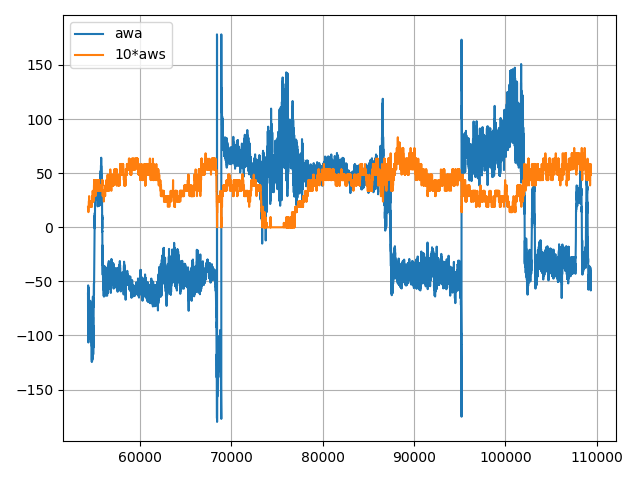

<IPython.core.display.Javascript object>


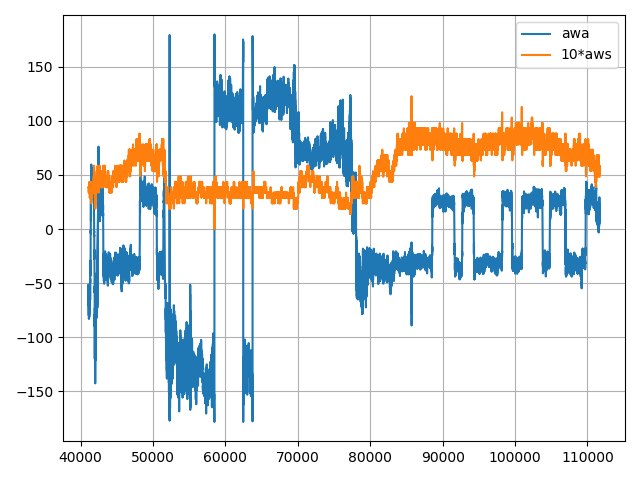

In [20]:
wdf = dfs[0]
c.quick_plot(wdf.index, (wdf.rawa, 10*wdf.raws), "awa 10*aws".split())
wdf = dfs[1]
c.quick_plot(wdf.index, (wdf.rawa, 10*wdf.raws), "awa 10*aws".split())

### Noise is related to speed, even within a single race.

When racing, most of the time we sail to a constant "target" AWA (for max VMG).  As a result we will see the "square wave" we mentioned above: constant AWA with periodic large jumps. There will be natural variations, but notice in both above graphs when AWS is below 3 m/s (6 knots) the noise is measurably larger (perhaps double).

In particular, in the first graph look at `[72000, 80000]`.  The "noise" in AWA is massive.

In general when sailing downwind the AWS is lower (since we are sailing away from the wind), this consistently increases noise.

But also recall that we needed to select a `max_error` threshold, and that this threshold is basically equal to the noise we expect to see.  In the new datasets above I've found that 12 works best for first (low wind) and 6 for the second (higher wind).  Unfortunately wind can change throughout the race.

So now we need a threshold that is either too large (so it works all the time) or one that is adjusted based on AWS?

Why is a too large threshold bad?  It will introduce too much delay in tacks.  Why is a too small threshold bad? It will treat noise as signal and let more noise through.

One approach is to avoid angular smoothing altogether.  Rather than process AWA and AWS separately, they can be combined into an estimate of two components of wind speed (no angles!): "boat north" which blows acorss the bow, and "boat east" which plows to port.  These components can be easily recombined to form AWS and AWA.


In [21]:
import importlib
importlib.reload(c)

<module 'chart' from '/Users/viola/GDriveBV/Sailboat/Code/Python/sailing/chart.py'>

<IPython.core.display.Javascript object>


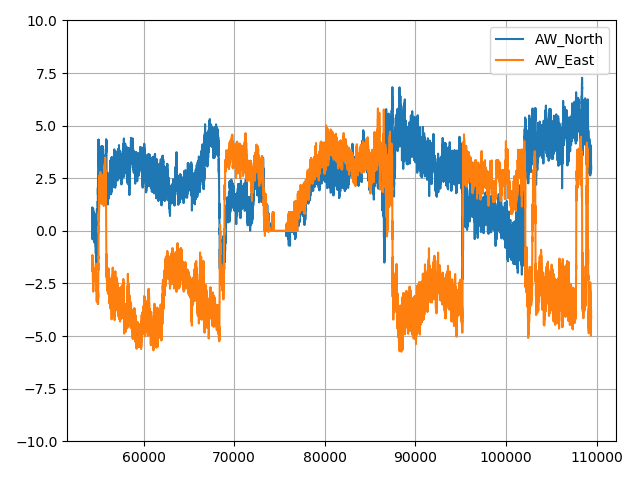

<IPython.core.display.Javascript object>


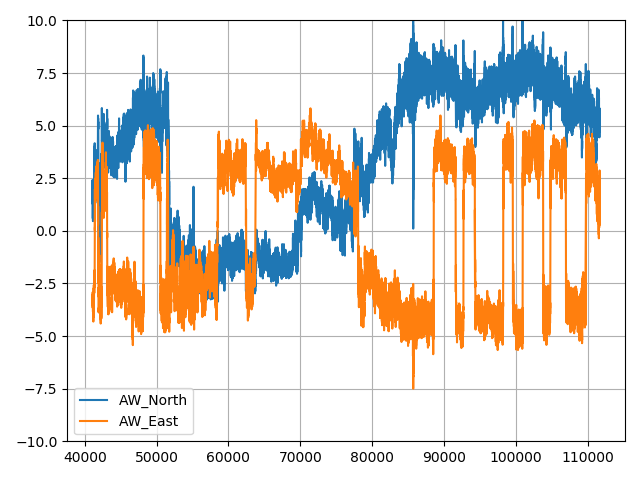

In [22]:
# Let's break apparent wind into two components, "boat north" and "boat east".  
# Boat north points to the bow.  Boat east points to starboard.  (This will be of value as we estimate TWA as well.)
# fig = plt.figure()v
for df in dfs:
    df['aw_n'] = df.raws * p.cos_d(df.rawa)
    df['aw_e'] = df.raws * p.sin_d(df.rawa)

    c.quick_plot(df.index, (df.aw_n, df.aw_e), "AW_North AW_East".split(), ylim=(-10, 10)) # fignum=fig, clf=False)


### Noise is now much more consistent

First note that the noise is much more consistent between the two days.  By eye,  but it looks like the noise is roughly 1-2 m/s.

Also note, that in the near zero wind condition (`[72000, 80000]` in the first graph above) we do not have massive increase in the noise (as we did before).

The new approach is then to smooth in aw_e and aw_n separately and then recombine.


In [23]:
p.exponential_filter(np.array(df.aw_n), alpha, theta)

(array([2.0393, 2.0393, 2.0407, ..., 5.2545, 5.25  , 5.2343]),
 array([0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03]))

In [24]:
for df in dfs:
    theta = 6 # the threshold, which should be approximate the noise 
    alpha = 0.97
    df['sawa_alpha_theta'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, theta)    

    theta = 0.8
    alpha = 0.97
    df['saw_n'], _ = p.exponential_filter(np.array(df.aw_n), alpha, theta)
    df['saw_e'], _ = p.exponential_filter(np.array(df.aw_e), alpha, theta)
    
    df['sawa'] = np.degrees(np.arctan2(df.saw_e, df.saw_n))
    df['saws'] = np.sqrt(np.square(df.saw_e) + np.square(df.saw_n))


<IPython.core.display.Javascript object>


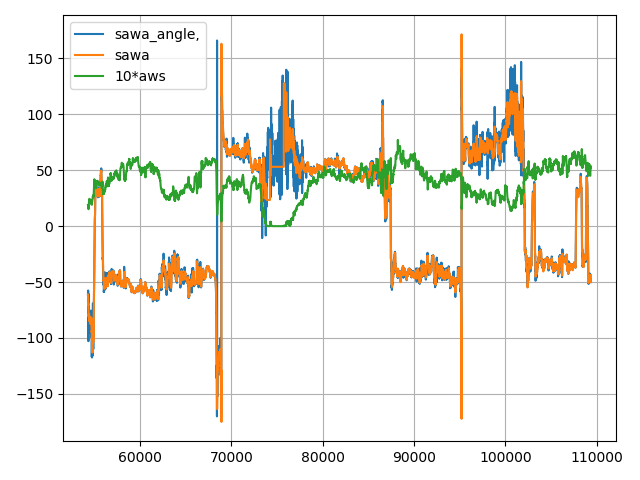

<IPython.core.display.Javascript object>


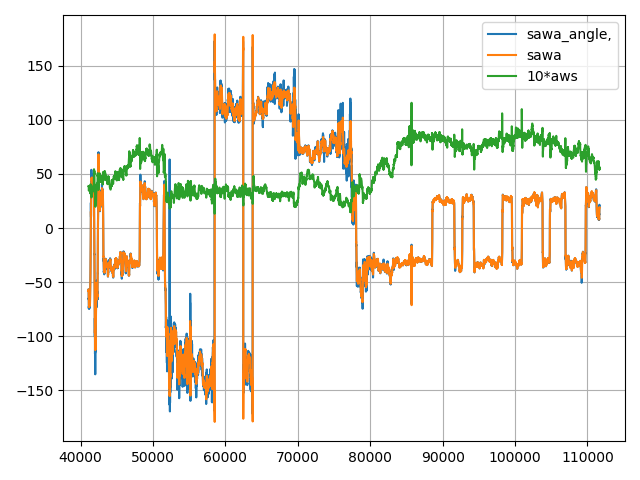

In [25]:
for df in dfs:
    c.quick_plot(df.index, (df.sawa_alpha_theta, df.sawa, 10*df.saws), "sawa_angle, sawa 10*aws".split())

### New AWA results are much more stable

Notice in the above graphs:

- The new results are "better" (smoother, more consistent) when wind speed is low.
- The new results are quite similar to previous estimates when the wind speed is higher.

The advantage of the new process is that this same filtering parameters work equally well in varying wind conditions.

<IPython.core.display.Javascript object>


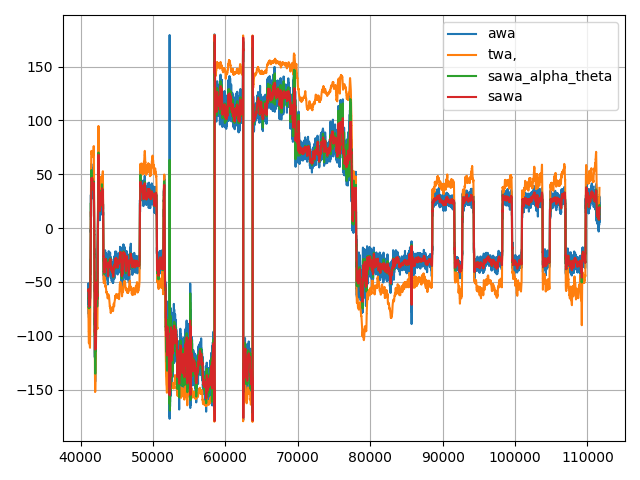

<IPython.core.display.Javascript object>


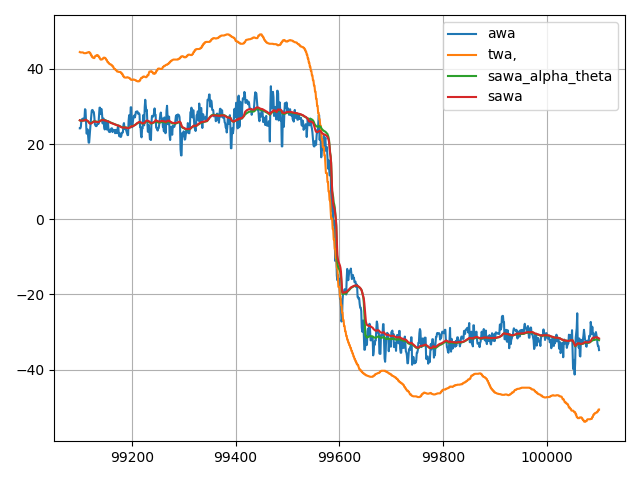

<IPython.core.display.Javascript object>


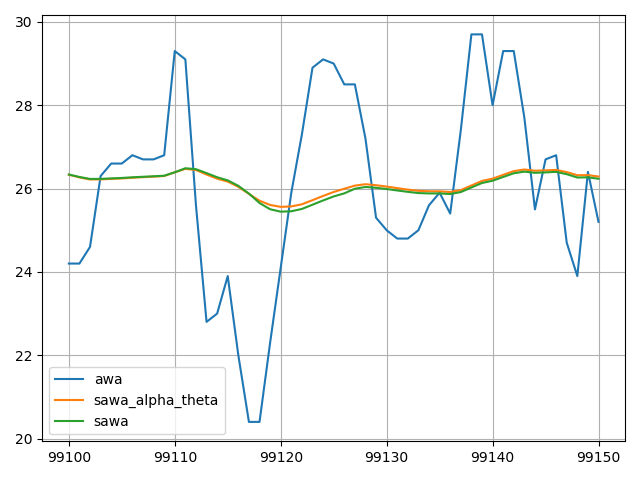

In [26]:
# Let's compare with the previous "angle based" results.

df = dfs[1]


wdf = df
c.quick_plot(wdf.index, (wdf.rawa, wdf.rtwa, wdf.sawa_alpha_theta, wdf.sawa), 
                        "awa twa, sawa_alpha_theta sawa".split())

wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.rtwa, wdf.sawa_alpha_theta, wdf.sawa), 
                        "awa twa, sawa_alpha_theta sawa".split())

wdf = df.loc[narrow_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa_alpha_theta, wdf.sawa), 
                        "awa sawa_alpha_theta sawa".split())



# Conclusions

- Raw instruments are measured with sensors that are quite noisy.
- We have demonstrated various techniques for filtering this noise to remove it.
   - The best approach appears to be a non-linear exponential filter.  This filter is simple, inexpensive, and handles real sailing data well.
- Additionally direct processing of angle data (like AWA) is tricky, we provide a technique which works better.
